In [1]:
import os.path as osp
import pickle
import random

import numpy as np
import time
import torch

import lmdb

import numpy as np
from torch.utils.data import Dataset
import torchvision
import kornia
from skimage.color import lab2rgb


from collections import OrderedDict
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel

# pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import signal

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import warnings
warnings.filterwarnings("ignore")

/home/moose-linux-pc/miniconda3/envs/torch-rocm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hyperparameters

In [2]:
BATCH_SIZE = 16
TEMPO_LENGTH = 1 # (only used while trianing)
SIZE = 256

### Dataset

In [3]:
def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

class BaseDataset(Dataset):
    def __init__(self, data_opt, **kwargs):
        # dict to attr
        for kw, args in data_opt.__dict__.items():
            setattr(self, kw, args)


    def __len__(self):
        pass

    def __getitem__(self, item):
        pass

   
    @staticmethod
    def init_lmdb(seq_dir):
        env = lmdb.open(
            seq_dir, readonly=True, lock=False, readahead=False, meminit=False)
        return env

    @staticmethod
    def parse_lmdb_key(key):
        key_lst = key.split('_')
        idx, size, frm = key_lst[:-2], key_lst[-2], int(key_lst[-1])
        idx = '_'.join(idx)
        size = tuple(map(int, size.split('x')))  # n_frm, h, w
        return idx, size, frm

    @staticmethod
    def read_lmdb_frame(env, key, size):
        with env.begin(write=False) as txn:
            buf = txn.get(key.encode('ascii'))
        frm = np.frombuffer(buf, dtype=np.uint8).reshape(*size)
        return frm

    def crop_sequence(self, **kwargs):
        pass

    @staticmethod
    def augment_sequence(**kwargs):
        pass


class PairedLMDBDataset(BaseDataset):
    """ LMDB dataset for paired data (for BI degradation)
    """

    def __init__(self, data_opt, **kwargs):
        super(PairedLMDBDataset, self).__init__(data_opt, **kwargs)
        
        self.lr_seq_dir = data_opt.lr_seq_dir
        self.data_type = data_opt.data_type
        self.scale = data_opt.scale
        self.tempo_extent = data_opt.tempo_extent
        self.moving_first_frame = data_opt.moving_first_frame
        self.moving_factor = data_opt.moving_factor
        self.filter_file = data_opt.filter_file
        
        self.transform = torchvision.transforms.Compose([torchvision.transforms.Resize((256, 256))])

        # load meta info
        lr_meta = pickle.load(
            open(osp.join(self.lr_seq_dir, 'meta_info.pkl'), 'rb'))
        self.lr_keys = sorted(lr_meta['keys'])
        
        # register parameters
        self.lr_env = None

    def __len__(self):
        return len(self.lr_keys)

    def __getitem__(self, item):
        if self.lr_env is None:
            self.lr_env = self.init_lmdb(self.lr_seq_dir)

        # parse info
        lr_key = self.lr_keys[item]
        idx, (tot_frm, lr_h, lr_w), cur_frm = self.parse_lmdb_key(lr_key)

        c = 3 if self.data_type.lower() == 'rgb' else 1
        
        # get frames
        lr_frms = []
        if self.moving_first_frame and (random.uniform(0, 1) > self.moving_factor):
            # load the first gt&lr frame
            lr_frm = self.read_lmdb_frame(
                self.lr_env, lr_key, size=(lr_h, lr_w, c))
            lr_frm = lr_frm.transpose(2, 0, 1)  # chw|rgb|uint8

            # generate random moving parameters
            offsets = np.floor(
                np.random.uniform(-1.5, 1.5, size=(self.tempo_extent, 2)))
            offsets = offsets.astype(np.int32)
            pos = np.cumsum(offsets, axis=0)
            min_pos = np.min(pos, axis=0)
            topleft_pos = pos - min_pos
            range_pos = np.max(pos, axis=0) - min_pos
            c_h, c_w = lr_h - range_pos[0], lr_w - range_pos[1]

            # generate frames
            for i in range(self.tempo_extent):
                lr_top, lr_left = topleft_pos[i]
                lr_frms.append(lr_frm[
                    :, lr_top: lr_top + c_h, lr_left: lr_left + c_w].copy())

        else:
            # read frames
            for i in range(cur_frm, cur_frm + self.tempo_extent):
                if i >= tot_frm:
                    # reflect temporal paddding, e.g., (0,1,2) -> (0,1,2,1,0)
                    lr_key = '{}_{}x{}x{}_{:04d}'.format(
                        idx, tot_frm, lr_h, lr_w, 2 * tot_frm - i - 2)
                else:
                    lr_key = '{}_{}x{}x{}_{:04d}'.format(
                        idx, tot_frm, lr_h, lr_w, i)

                lr_frm = self.read_lmdb_frame(
                    self.lr_env, lr_key, size=(lr_h, lr_w, c))
                lr_frm = lr_frm.transpose(2, 0, 1)
                lr_frms.append(lr_frm)

        lr_frms = np.stack(lr_frms)
        lr_tsr = torch.FloatTensor(np.ascontiguousarray(lr_frms)) / 255
        lr_tsr = self.transform(lr_tsr)

        lr_tsr = kornia.color.rgb_to_lab(lr_tsr)
        L = lr_tsr[:, 0:1, :, :]
        ab = lr_tsr[:, 1:, :, :]
        
        L = L/ 50. - 1. # Between -1 and 1
        ab = ab / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}

 
    @staticmethod
    def augment_sequence(gt_pats, lr_pats):
        # flip
        axis = random.randint(1, 3)
        if axis > 1:
            gt_pats = np.flip(gt_pats, axis)
            lr_pats = np.flip(lr_pats, axis)

        # rotate 90 degree
        k = random.randint(0, 3)
        gt_pats = np.rot90(gt_pats, k, (2, 3))
        lr_pats = np.rot90(lr_pats, k, (2, 3))

        return gt_pats, lr_pats
    

class DatasetConfig:
    def __init__(self, 
                 lr_seq_dir,
                 data_type='rgb',
                 scale=1,
                 tempo_extent=5,
                 moving_first_frame=False,
                 moving_factor=0.5,
                 filter_file=None):
        self.lr_seq_dir = lr_seq_dir
        self.data_type = data_type
        self.scale = scale
        self.tempo_extent = tempo_extent
        self.moving_first_frame = moving_first_frame
        self.moving_factor = moving_factor
        self.filter_file = filter_file

data_opt = DatasetConfig(
    lr_seq_dir='/media/moose-linux-pc/Moose/Dataset/AMD/',
    data_type='rgb',
    scale=1,
    tempo_extent=TEMPO_LENGTH,
    moving_first_frame=False,
    moving_factor=0.5,
    filter_file=None
)

ds = PairedLMDBDataset(data_opt)

In [4]:
train_loader = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

### Loss function

In [5]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

### Models

In [6]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [7]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [8]:
def build_res_unet(n_input=1, n_output=2, size=SIZE):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18(), pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [9]:
class NDIM_LSTM(nn.Module):
    
    def __init__(self,size):
        super().__init__()

        self.percent_ltr_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.percent_ltr_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b1=nn.Parameter(torch.tensor(0.),requires_grad=False)

        self.percent_potential_ltm_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.percent_potential_ltm_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b2=nn.Parameter(torch.tensor(0.),requires_grad=False)
        
        self.potential_ltm_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.potential_ltm_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b3=nn.Parameter(torch.tensor(0.),requires_grad=False)
        
        self.output_stm_contri_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.output_stm_contri_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b4=nn.Parameter(torch.tensor(0.),requires_grad=False)

    def lstm_unit(self,input_value,long_memory,short_memory):
        
        long_remember_percent=torch.sigmoid((input_value*self.percent_ltr_input)+
                                            (self.percent_ltr_stm_wt*short_memory)+
                                            self.b1)
        
        potential_remember_percent=torch.sigmoid((input_value*self.percent_potential_ltm_input)+
                                                 (short_memory*self.percent_potential_ltm_stm_wt)+
                                                  self.b2)

        potential_memory = torch.tanh((short_memory * self.potential_ltm_stm_wt) + 
                                  (input_value * self.potential_ltm_input) + 
                                  self.b3)
        
        updated_long_memory = ((long_memory * long_remember_percent) + 
               (potential_remember_percent * potential_memory))

        output_percent = torch.sigmoid((short_memory * self.output_stm_contri_stm_wt) + 
                                       (input_value * self.output_stm_contri_input) + 
                                       self.b4)         
        
        updated_short_memory = torch.tanh(updated_long_memory) * output_percent
        
        
        updated_long_memory = torch.tanh(updated_long_memory)
        updated_short_memory = torch.tanh(updated_short_memory)
        
        return([updated_long_memory, updated_short_memory])

    def forward(self, input, long_memory=0, short_memory=0): 
        
        return self.lstm_unit(input,long_memory,short_memory)

In [10]:
class ColorNet(nn.Module):
    def __init__(self,pretrained_weights=None):
        super().__init__()
        self.unet_part1 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=9, stride=1, padding='same').to(device)
        self.unet_part2 = build_res_unet(n_input=1, n_output=2, size=SIZE)
        self.lstm = NDIM_LSTM((2,SIZE,SIZE)).to('cuda' if torch.cuda.is_available() else 'cpu')
        if(pretrained_weights is not None):
            print(self.unet_part2.load_state_dict(torch.load(pretrained_weights)))
        
    
    def forward(self, L, prev_ab = None):
        if(prev_ab is None):
            #print(torch.squeeze(L,dim=1).shape)
            L = torch.squeeze(L,dim=1)
            n,c,h,w = L.shape
            prev_ab = torch.zeros(n, 2, h, w, device='cuda' if torch.cuda.is_available() else 'cpu', dtype=torch.float32)
        x = torch.concat([L, prev_ab], dim=1)
        part1 = self.unet_part1(x)
        #print(part1.shape)
        pred_ab = self.unet_part2(part1)
        stm, ltm = self.lstm(pred_ab)
        return {'pred_ab': pred_ab, 'stm': stm, 'ltm': ltm}
        

In [11]:
class ColorNetGAN(nn.Module):
    def __init__(self, net_G=None,path=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            if(path is not None):
                self.net_G = ColorNet(path).to(self.device)
            else:
                self.net_G = ColorNet().to(self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = torch.optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = torch.optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        n, self.t, c, lr_h, lr_w = self.L.size()
        ab_data = []
        
        preds = self.net_G(torch.unsqueeze(self.L[:, 0, ...],dim=1))
        
        
        ab_data.append(preds['stm'])

        # compute the remaining hr data
        for i in range(1, self.t):
            ab_curr = self.net_G(self.L[:, i, ...], ab_data[i-1])
            ab_data.append(ab_curr['stm'])

        self.ab_data = torch.stack(ab_data, dim=1)

    def backward_D(self):
        self.loss_D_fake = 0
        self.loss_D_real = 0

        for i in range(self.t):
            fake_image = torch.cat([self.L[:, i, ...], self.ab_data[:, i, ...]], dim=1)
            fake_preds = self.net_D(fake_image.detach())
            self.loss_D_fake += self.GANcriterion(fake_preds, False)

            real_image = torch.cat([self.L[:, i, ...], self.ab[:, i, ...]], dim=1)
            real_preds = self.net_D(real_image)
            self.loss_D_real += self.GANcriterion(real_preds, True)

        #self.loss_D_fake /= self.t                                              # I don't think we should divide by t here
        #self.loss_D_real /= self.t                                              # I don't think we should divide by t here
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        self.loss_G_GAN = 0
        self.loss_G_L1 = 0

        for i in range(self.t):
            fake_image = torch.cat([self.L[:, i, ...], self.ab_data[:, i, ...]], dim=1)
            fake_preds = self.net_D(fake_image)
            self.loss_G_GAN += self.GANcriterion(fake_preds, True)
            self.loss_G_L1 += self.L1criterion(self.ab_data[:, i, ...], self.ab[:, i, ...]) * self.lambda_L1

        #self.loss_G_GAN /= self.t                                                               # I don't think we should divide by t here
        #self.loss_G_L1 /= self.t                                                                # I don't think we should divide by t here
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()


In [12]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)




def visualize(model, data, save=True, show=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.ab_data.detach()
    real_color = model.ab
    L = model.L

    # Reshape or loop through the temporal dimension
    batch_size, temporal_dim = L.shape[0], L.shape[1]
    fake_imgs = []
    real_imgs = []
    for i in range(batch_size):
        for t in range(temporal_dim):
            fake_imgs.append(lab_to_rgb(L[i, t].unsqueeze(0), fake_color[i, t].unsqueeze(0)))
            real_imgs.append(lab_to_rgb(L[i, t].unsqueeze(0), real_color[i, t].unsqueeze(0)))

    # Increase figure size
    fig, axes = plt.subplots(nrows=3 * batch_size, ncols=temporal_dim, figsize=(temporal_dim * 5, 3 * batch_size * 5))
    for i in range(batch_size):
        for t in range(temporal_dim):
            idx = t
            axes[3 * i][idx].imshow(L[i, t][0].cpu(), cmap='gray')
            axes[3 * i][idx].axis("off")
            axes[3 * i + 1][idx].imshow(np.squeeze(fake_imgs[i * temporal_dim + t]))
            axes[3 * i + 1][idx].axis("off")
            axes[3 * i + 2][idx].imshow(np.squeeze(real_imgs[i * temporal_dim + t]))
            axes[3 * i + 2][idx].axis("off")

    plt.tight_layout(pad=2.0)

    if save:
        fig.savefig(f"colorization_{time.time()}.png")
    if show:
        plt.show()
    plt.close(fig)  # Close the figure to avoid residual display issues

    
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [13]:
model1=ColorNet('generator.pt')

<All keys matched successfully>


In [14]:
data1=next(iter(train_loader))

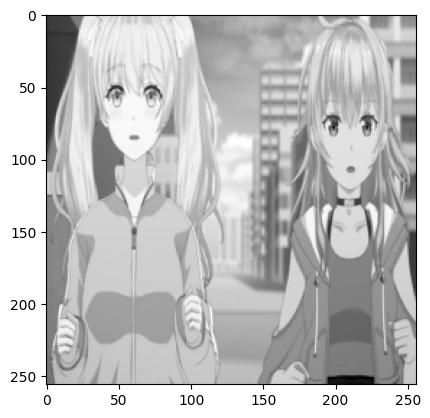

In [17]:
plt.imshow(data1['L'][4][0].permute(1,2,0),cmap='grey')

In [18]:
L = data1['L'][4][0] * 50.
ab = data1['ab'][4][0] * 110.
Lab = torch.cat([L, ab], dim=0)
img_rgb = lab2rgb(Lab.permute(1,2,0))

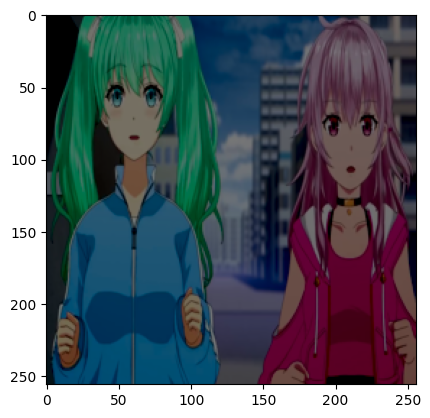

In [19]:
plt.imshow(img_rgb)

In [21]:
torch.unsqueeze(data1['L'][4][0],dim=0).shape

torch.Size([1, 1, 256, 256])

In [22]:
result=model1(torch.unsqueeze(data1['L'][4][0],dim=0).to(device),torch.rand(1,2,256,256).to(device))

torch.Size([1, 1, 256, 256])


In [23]:
L.shape,ab.shape

(torch.Size([1, 256, 256]), torch.Size([2, 256, 256]))

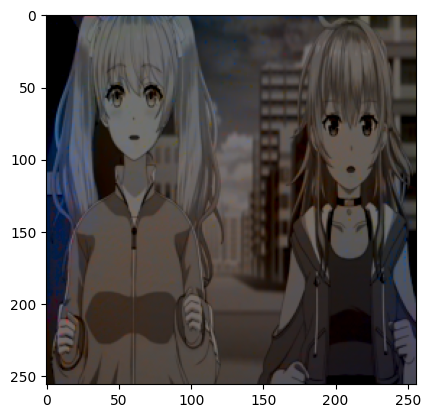

In [24]:
L = data1['L'][4][0] * 50.
ab = result['pred_ab'][0] * 110.
Lab = torch.cat([L, ab.to('cpu')], dim=0)
img_rgb = lab2rgb(Lab.permute(1,2,0).detach().numpy())
plt.imshow(img_rgb)

In [25]:
data1['ab'][0][0].shape

torch.Size([2, 256, 256])

In [ ]:
model1()

In [ ]:
model=ColorNetGAN(path='/media/moose-linux-pc/Storage/ColorNet/Notebooks/generator.pt')
data=next(iter(train_loader))
visualize(model, data, save=False,show=True)

In [26]:
def train_model(model, train_dl, epochs, display_every=200):
    for e in range(epochs+1):
        loss_meter_dict = create_loss_meters() # function returning a dictionary of objects to log the losses of the complete network
        progress_bar = tqdm(enumerate(train_dl), total=len(train_dl), desc=f"Epoch {e+1}/{epochs}")
        
        for i, data in progress_bar:
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects

            if i % display_every == 0 or (i == 0 and e==0):
                if(e==0):
                    print(f"\nEpoch {e}/{epochs}")
                else:
                    print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs
                
                progress_bar.set_postfix({
                    'loss_D_fake': loss_meter_dict['loss_D_fake'].avg,
                    'loss_D_real': loss_meter_dict['loss_D_real'].avg,
                    'loss_D': loss_meter_dict['loss_D'].avg,
                    'loss_G_GAN': loss_meter_dict['loss_G_GAN'].avg,
                    'loss_G_L1': loss_meter_dict['loss_G_L1'].avg,
                    'loss_G': loss_meter_dict['loss_G'].avg
                })
                torch.save(model.state_dict(),'latest_weights.pt')

        print(f"Epoch {e + 1}/{epochs}")
        log_results(loss_meter_dict)

#model = MainModel()
#train_model(model, train_loader, 100)

In [27]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs, display_every=200):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net_G.to(device)
    
    for e in range(epochs):
        loss_meter = AverageMeter()
        progress_bar = tqdm(enumerate(train_dl), total=len(train_dl), desc=f"Epoch {e+1}/{epochs}")
        
        for i, data in progress_bar:
            L, ab = data['L'].to(device), data['ab'].to(device)
            
            n, t, c, lr_h, lr_w = L.size()
            ab_data = []
            
            preds = net_G(torch.unsqueeze(L[:, 0, ...], dim=1))
            ab_data.append(preds['stm'])

            # compute the remaining hr data
            for j in range(1, t):
                ab_curr = net_G(L[:, j, ...], ab_data[j-1])
                ab_data.append(ab_curr['stm'])

            ab_data = torch.stack(ab_data, dim=1)

            loss = 0
            for j in range(t):
                loss += criterion(ab_data[:, j, ...], ab[:, j, ...])

            #loss /= t
                
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))
            
            if i % display_every == 0:
                progress_bar.set_postfix({'L1 Loss': loss_meter.avg})
                torch.save(net_G.state_dict(),'latest_pretrained_weights.pt')

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")
        
        
#net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G=ColorNet('./generator.pt')
#print(net_G.load_state_dict(torch.load('./latest_pretrained_weights.pt')))
opt = torch.optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_loader, opt, criterion, 20)
#torch.save(net_G.state_dict(), "res18-unet.pt")

<All keys matched successfully>


Epoch 1/20:   0%|          | 0/2235 [00:00<?, ?it/s]

torch.Size([16, 1, 256, 256])


Epoch 1/20:   0%|          | 1/2235 [00:09<5:42:01,  9.19s/it, L1 Loss=0.0956]

torch.Size([16, 1, 256, 256])


Epoch 1/20:   0%|          | 2/2235 [00:11<3:11:18,  5.14s/it, L1 Loss=0.0956]

torch.Size([16, 1, 256, 256])


Epoch 1/20:   0%|          | 3/2235 [00:13<2:23:19,  3.85s/it, L1 Loss=0.0956]

torch.Size([16, 1, 256, 256])


Epoch 1/20:   0%|          | 4/2235 [00:16<1:59:45,  3.22s/it, L1 Loss=0.0956]

torch.Size([16, 1, 256, 256])


Epoch 1/20:   0%|          | 5/2235 [00:18<1:47:03,  2.88s/it, L1 Loss=0.0956]